In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, chi2
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler



online_shoppers_purchasing_intention_dataset = fetch_ucirepo(id=468)


X = online_shoppers_purchasing_intention_dataset.data.features
y = online_shoppers_purchasing_intention_dataset.data.targets


merged_df = pd.concat([X, y], axis=1)

print(merged_df.head())


   Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.20       0.20         0.0         0.0   Feb                 1   
1         0.00       0.10         0.0         0.0   Feb   

In [27]:
merged_df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


In [29]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

This is an interesting and fun dataset, with some great opportunities for insights. Here, we have a few items that are important to consider. Based on the description of this data, lets consider the following variables:

1) Administrative - Pertains to the type of webpage visited, and the count.
2) Administrative Duration - Represents the duration of time spent on the website.
3) Informational - Pertains to the type of webpage visited (informational), and the count.
4) Informational Duration - duration of time spent on these types of websites.
5) Product Related - This would be a product related website.
6) Product Duration of time on a product related website.
7) Bounce Rates - % of time the user left after visiting the first page. 
8) Exit Rates - % of time the webpage was the last one visited. 
9) Page Values - The average value for a web page that a user visited before completing an e-commerce transaction
10) Special Day - Closeness of purchase to a special day
11) Month - Month of purchase.
12) Operating Systems - OS of the user. 
13) Browser - Browser type
14) Region - Region of the purchaser
15) Traffic Type - Source type 
16) Visitor Type - returning or new customer. 
17) Weekend - Purchase on a weekend or weekday. 
18) Revenue - Amount of purchase. 


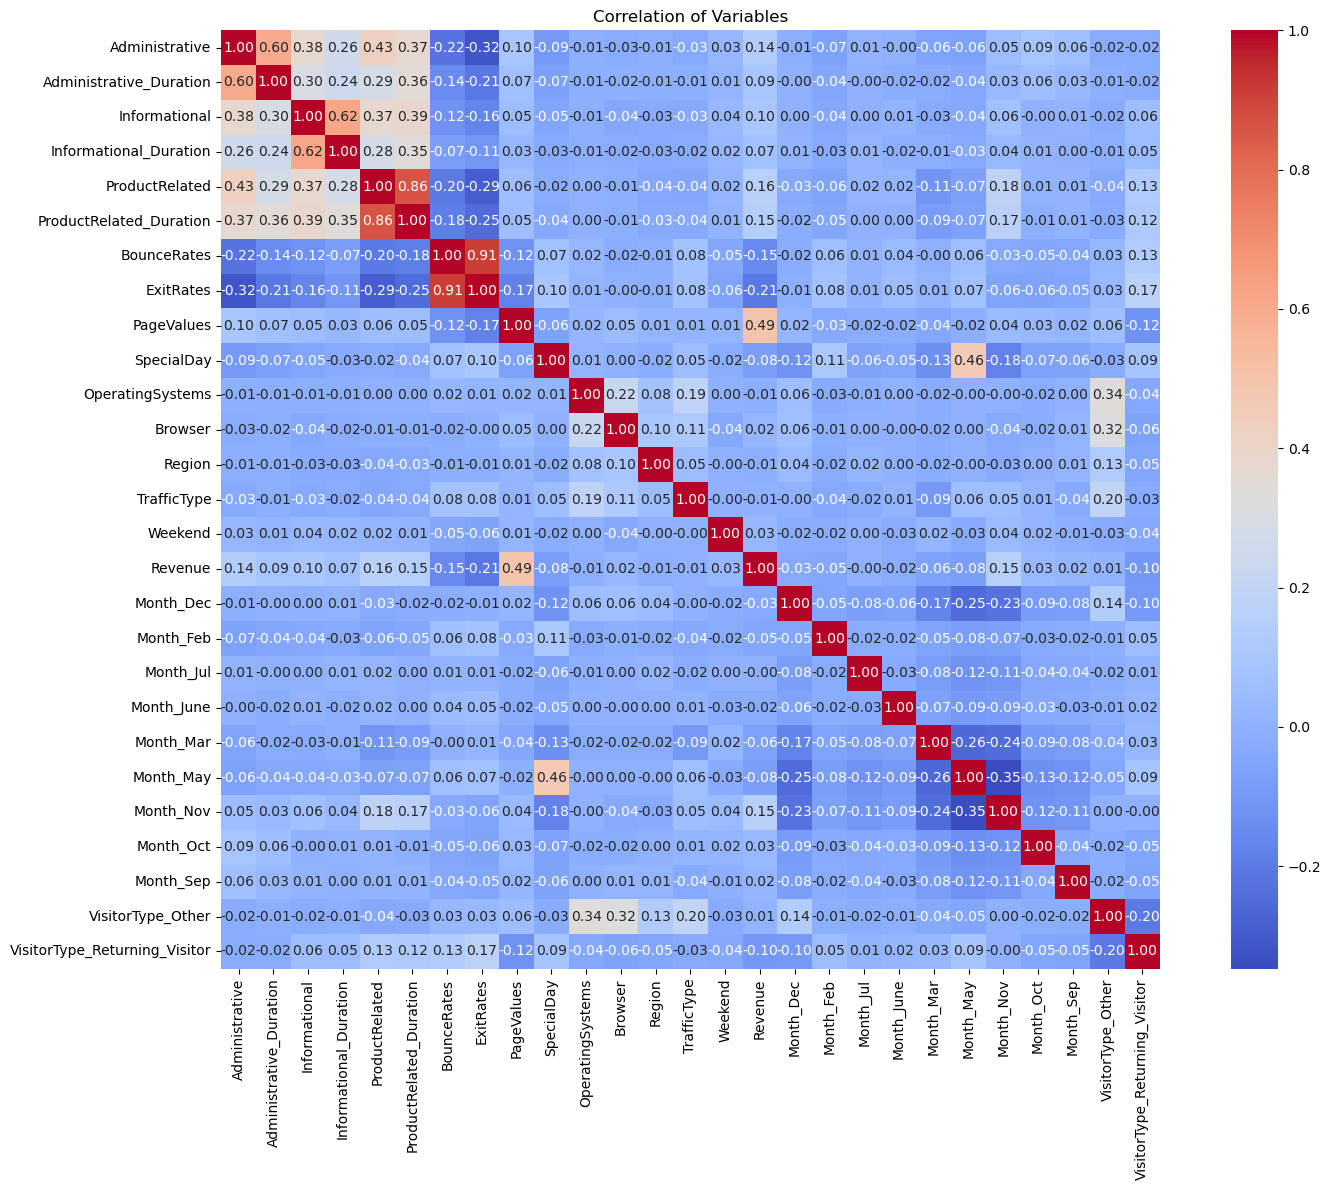

In [42]:
df_encoded_v1 = pd.get_dummies(merged_df, drop_first=True, dtype=int) 
le = LabelEncoder() 
df_encoded_v1['Revenue'] = le.fit_transform(merged_df['Revenue'])

corr = df_encoded_v1.corr() 

plt.figure(figsize=(16, 12)) 
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar=True) 
plt.title("Correlation of Variables") 
plt.tight_layout() 
plt.show()

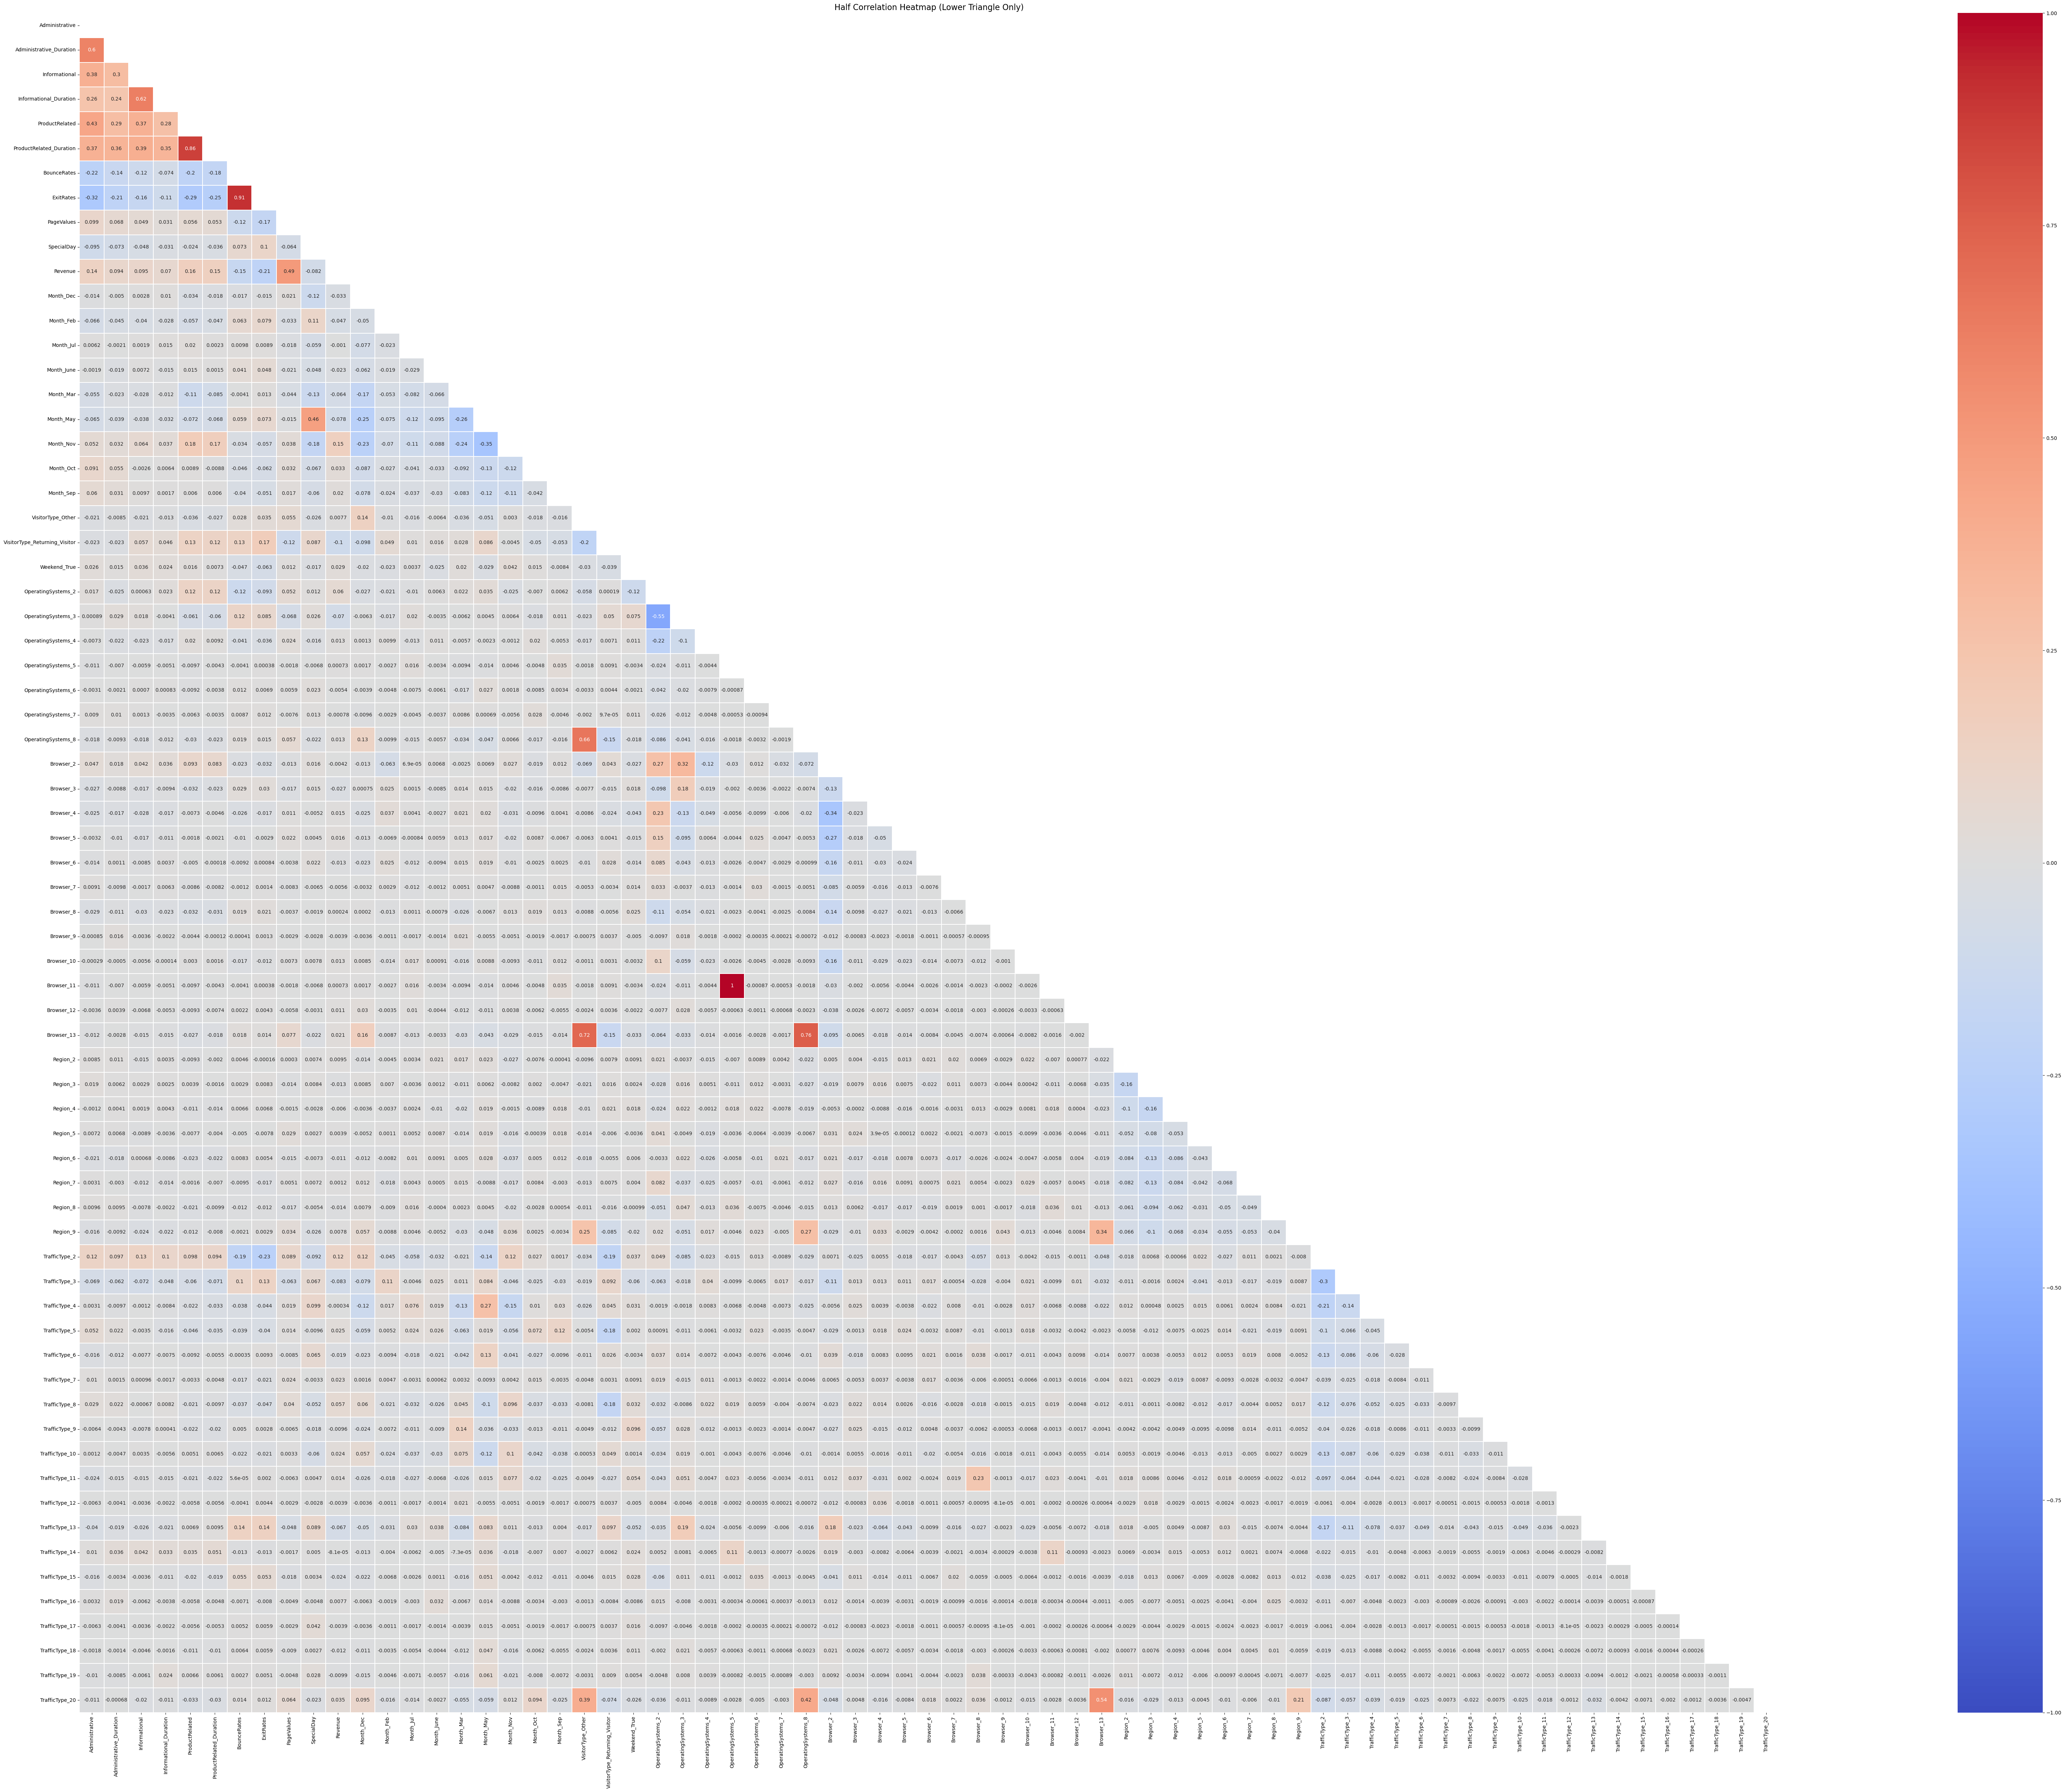

In [66]:
categorical_cols = [
    'Month',
    'VisitorType',
    'Weekend',
    'OperatingSystems',
    'Browser',
    'Region',
    'TrafficType'
]

df_encoded = pd.get_dummies(
    merged_df,
    columns=categorical_cols,
    drop_first=True,
    dtype=int
)

df_encoded['Revenue'] = LabelEncoder().fit_transform(merged_df['Revenue'])

corr = df_encoded.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(100, 50))
sns.heatmap(
    corr,
    mask=mask,                 
    annot=True,               
    cmap="coolwarm",
    vmax=1, vmin=-1,
    square=True,
    cbar=True,
    linewidths=0.3
)

plt.title("Half Correlation Heatmap (Lower Triangle Only)", fontsize=16)
plt.tight_layout()
plt.show()

As this is very much a work in progress, I thought it might be relevant to unpack the categorical variables. This offers a more behaviorally relevant correlation plot, which considers more individualized factors like operating system/ browser type. 

<Axes: xlabel='Revenue', ylabel='count'>

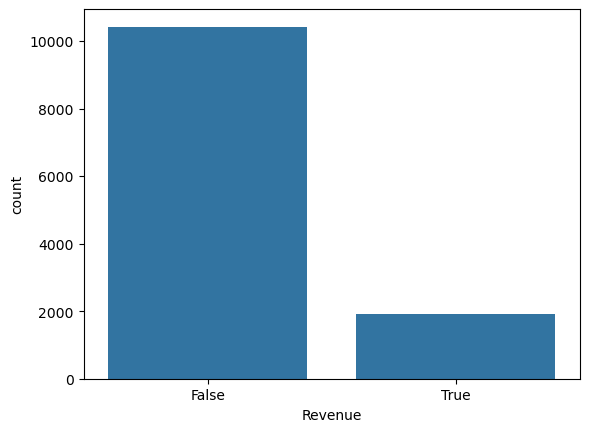

In [68]:
sns.countplot(data=merged_df, x="Revenue")

In [70]:
print(merged_df['Revenue'].value_counts())
purchase_rate = merged_df['Revenue'].mean()
print(f"purchase likelihood: {purchase_rate * 100:.2f}%")

Revenue
False    10422
True      1908
Name: count, dtype: int64
purchase likelihood: 15.47%


<Axes: xlabel='OperatingSystems', ylabel='count'>

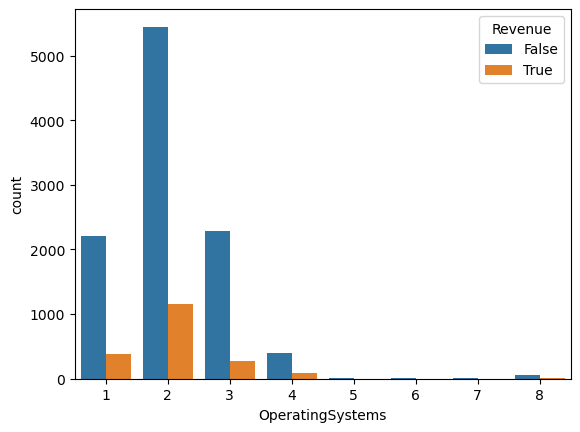

In [72]:
sns.countplot(data=merged_df, x="OperatingSystems", hue="Revenue")

<Axes: xlabel='OperatingSystems', ylabel='Revenue'>

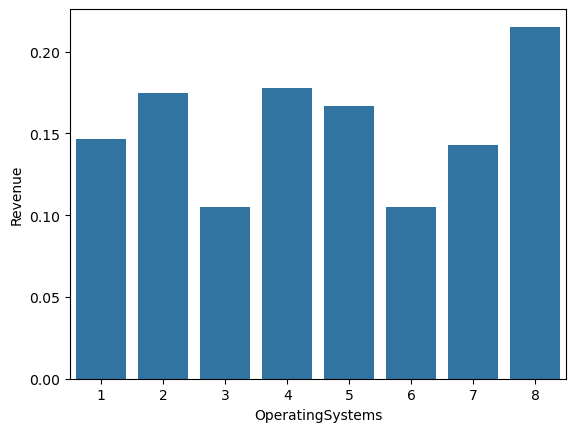

In [74]:
sns.barplot(data=merged_df, x="OperatingSystems", y="Revenue", errorbar=None)

In [76]:
os_counts = merged_df["OperatingSystems"].value_counts().sort_index()
print(os_counts)

OperatingSystems
1    2585
2    6601
3    2555
4     478
5       6
6      19
7       7
8      79
Name: count, dtype: int64


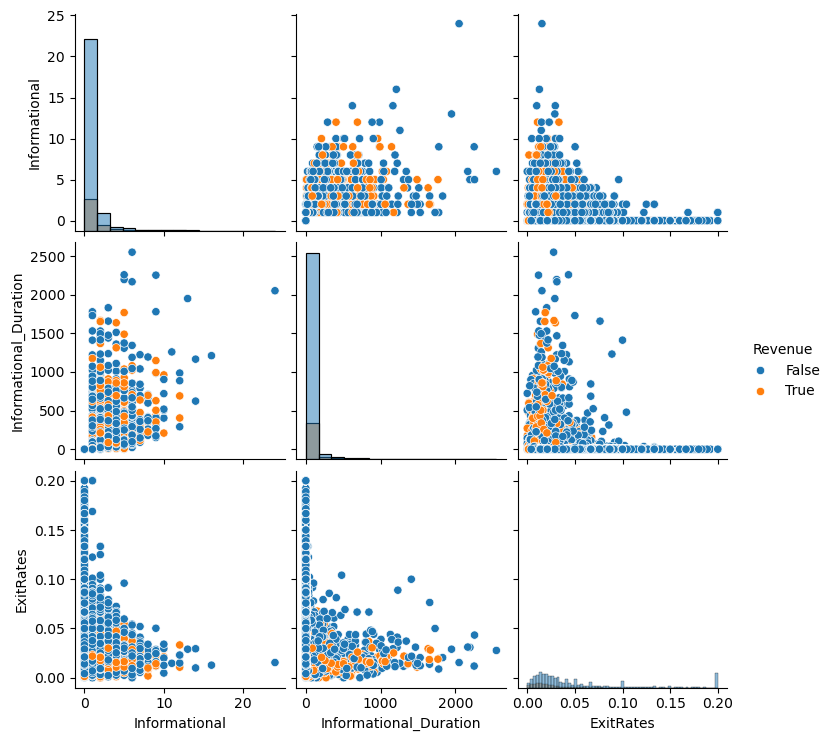

In [78]:
sns.pairplot(merged_df, vars=["Informational", "Informational_Duration", "ExitRates"], hue="Revenue", diag_kind="hist")

Text(0.5, 1.0, 'Conversion Rate: Visited Informational vs Not')

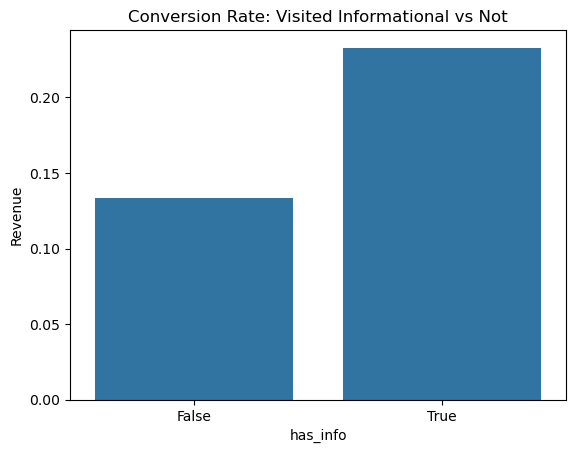

In [79]:
df = merged_df.copy()
df["has_info"] = (df["Informational"] > 0) | (df["Informational_Duration"] > 0)

cr = df.groupby("has_info")["Revenue"].mean().rename("conversion_rate")

sns.barplot(data=df, x="has_info", y="Revenue", estimator=np.mean, errorbar=None)
plt.title("Conversion Rate: Visited Informational vs Not")

<Axes: xlabel='has_info', ylabel='count'>

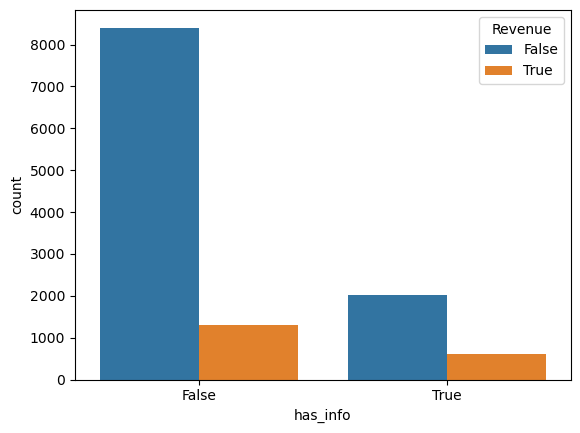

In [80]:
sns.countplot(
    data=df,
    x="has_info",
    hue="Revenue"
)

<Axes: xlabel='Revenue', ylabel='Informational_Duration'>

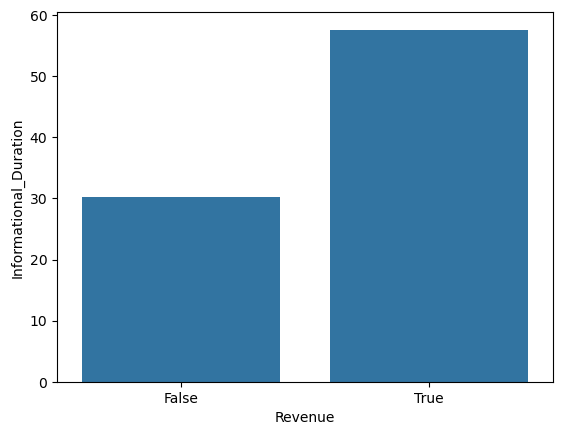

In [81]:
sns.barplot(data=merged_df, x = "Revenue", y = "Informational_Duration", errorbar=None)

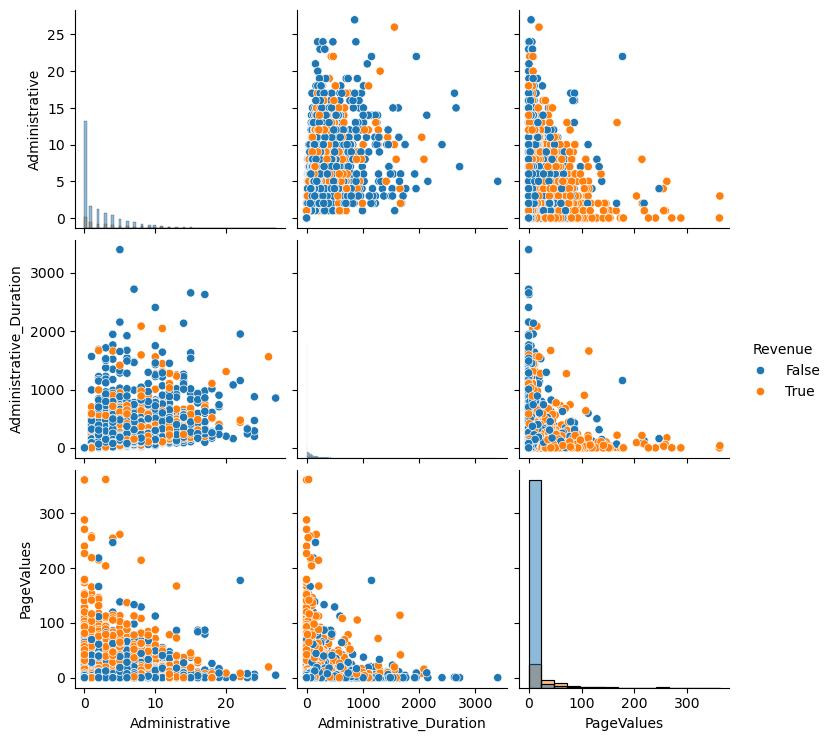

In [82]:
sns.pairplot(merged_df, vars=["Administrative", "Administrative_Duration", "PageValues"], hue="Revenue", diag_kind="hist")

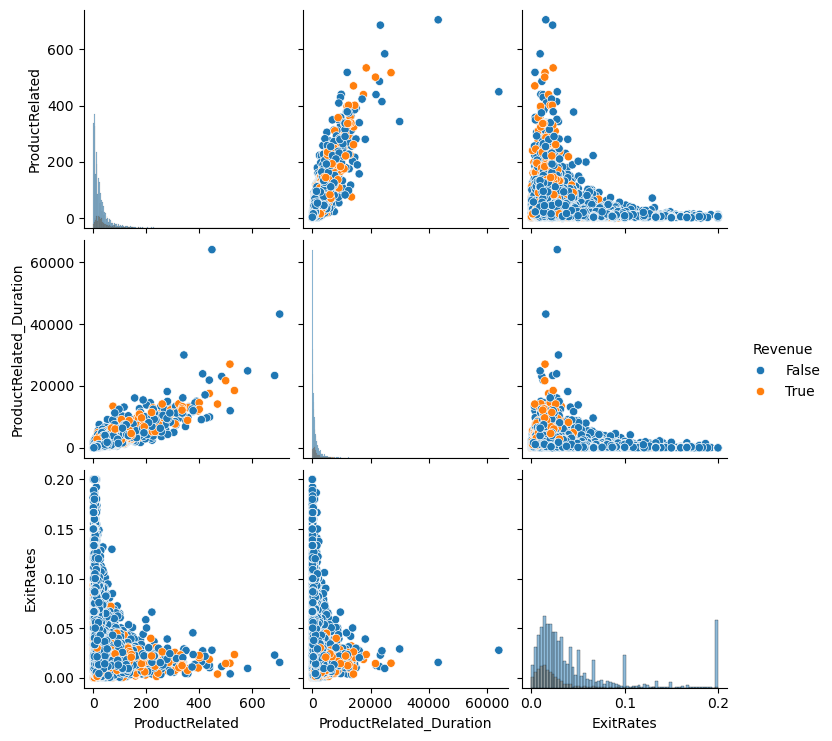

In [83]:
sns.pairplot(merged_df, vars=["ProductRelated", "ProductRelated_Duration", "ExitRates"], hue="Revenue", diag_kind="hist")

Similar patterns are noted with visits to informationa

<Axes: xlabel='Month', ylabel='count'>

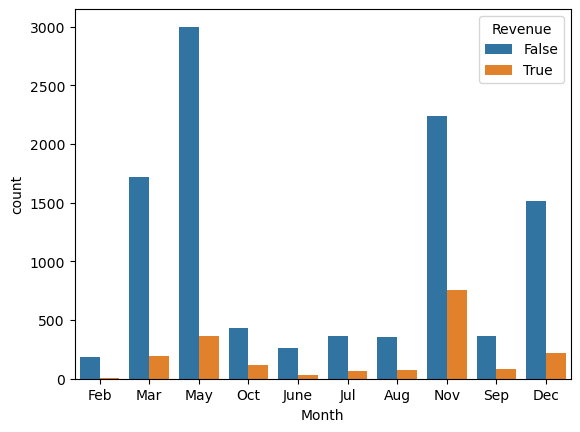

In [89]:
sns.countplot(data=merged_df, x="Month", hue = "Revenue")

In [90]:
month_counts = merged_df["Month"].value_counts().sort_index()
print(month_counts)

Month
Aug      433
Dec     1727
Feb      184
Jul      432
June     288
Mar     1907
May     3364
Nov     2998
Oct      549
Sep      448
Name: count, dtype: int64


<Axes: xlabel='Month', ylabel='Revenue'>

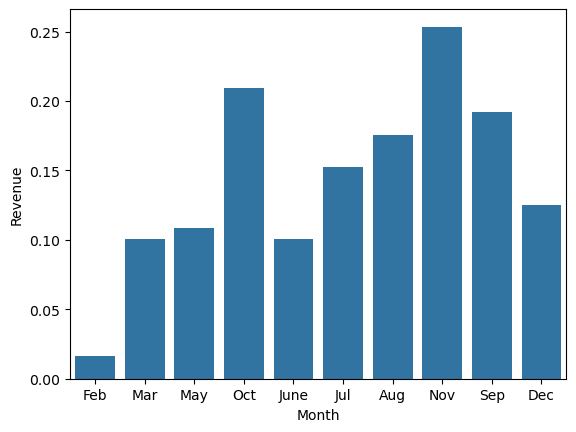

In [91]:
sns.barplot(data=merged_df, x="Month", y = "Revenue", errorbar=None)

<Axes: xlabel='VisitorType', ylabel='count'>

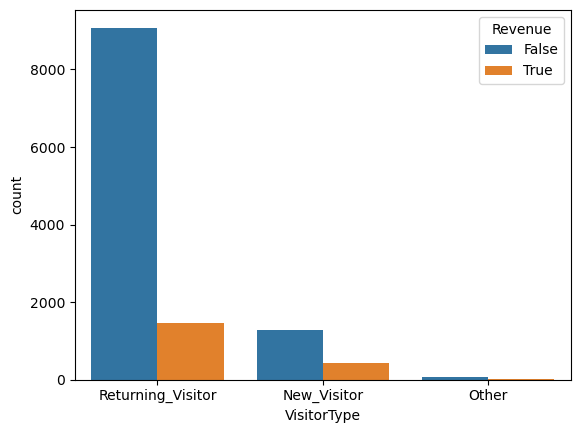

In [92]:
sns.countplot(data=merged_df, x="VisitorType", hue = "Revenue")

In [93]:
vis_counts = merged_df["VisitorType"].value_counts().sort_index()
print(vis_counts)

VisitorType
New_Visitor           1694
Other                   85
Returning_Visitor    10551
Name: count, dtype: int64


<Axes: xlabel='VisitorType', ylabel='Revenue'>

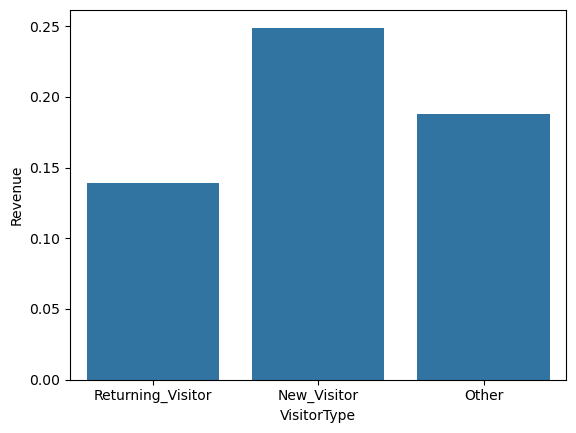

In [101]:
sns.barplot(data=merged_df, x="VisitorType", y = "Revenue", errorbar=None)

<Axes: xlabel='VisitorType', ylabel='PageValues'>

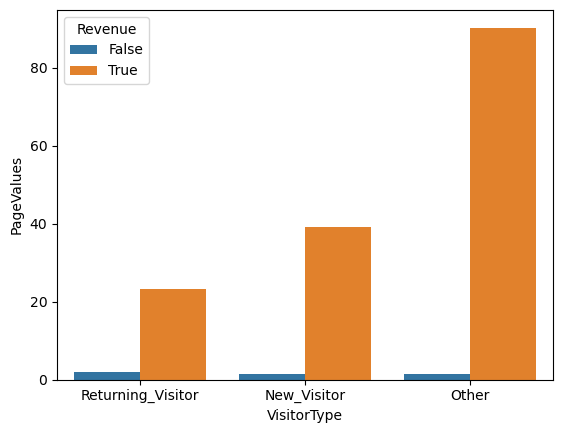

In [103]:
sns.barplot(data=merged_df, x="VisitorType", y = "PageValues", hue="Revenue", errorbar=None)

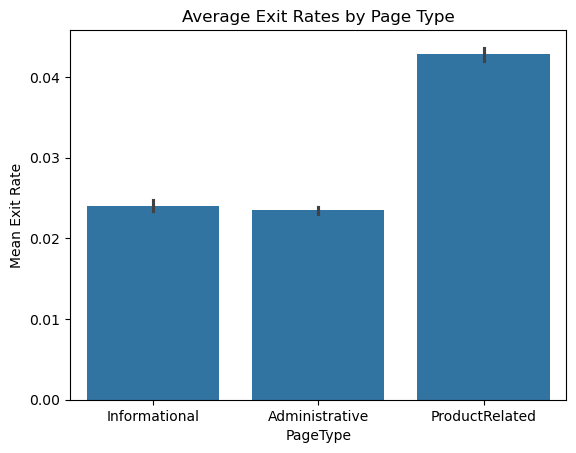

In [105]:
summary = {
    "Informational": merged_df.loc[merged_df["Informational"] > 0, "ExitRates"].mean(),
    "Administrative": merged_df.loc[merged_df["Administrative"] > 0, "ExitRates"].mean(),
    "ProductRelated": merged_df.loc[merged_df["ProductRelated"] > 0, "ExitRates"].mean()
}

pd.Series(summary).sort_values(ascending=False)


df_long = pd.melt(
    merged_df,
    id_vars=["ExitRates"],
    value_vars=["Informational", "Administrative", "ProductRelated"],
    var_name="PageType",
    value_name="Count"
)

df_long = df_long[df_long["Count"] > 0]

sns.barplot(data=df_long, x="PageType", y="ExitRates", estimator=np.mean, errorbar="ci")
plt.title("Average Exit Rates by Page Type")
plt.ylabel("Mean Exit Rate")
plt.show()



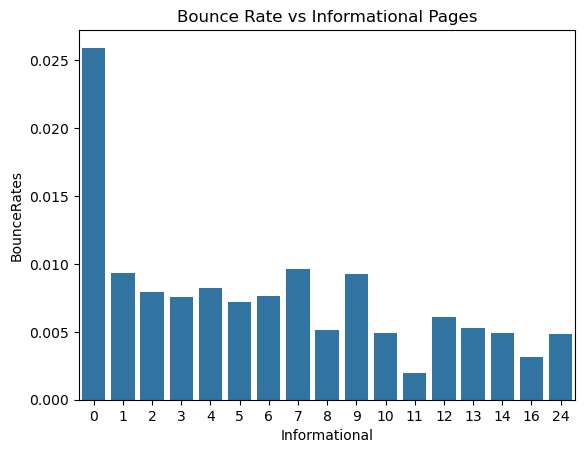

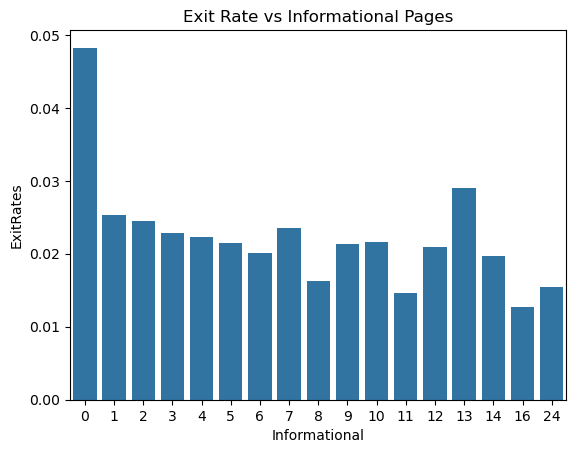

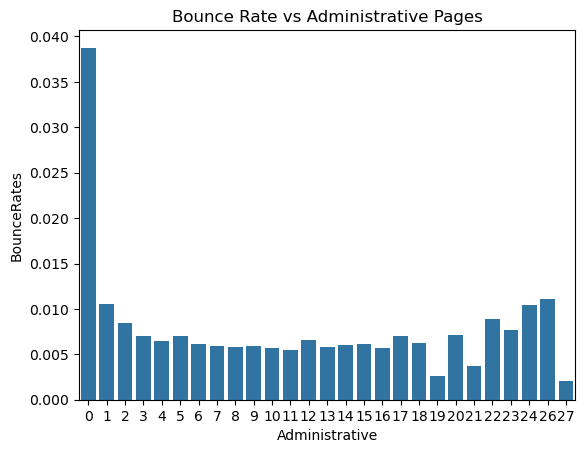

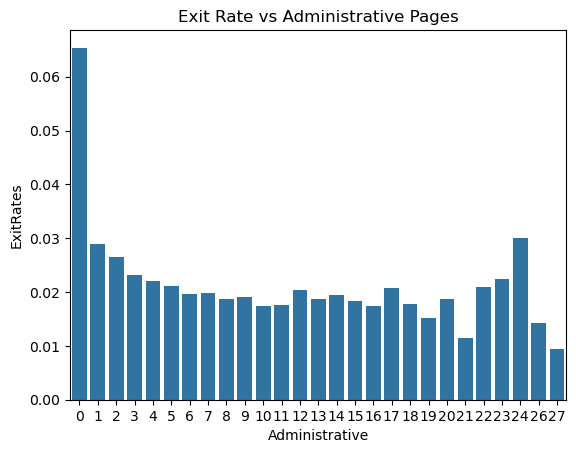

In [107]:
for col in ["Informational", "Administrative"]:
    sns.barplot(data=merged_df, x=col, y="BounceRates", errorbar=None)
    plt.title(f"Bounce Rate vs {col} Pages")
    plt.show()
    
    sns.barplot(data=merged_df, x=col, y="ExitRates", errorbar=None)
    plt.title(f"Exit Rate vs {col} Pages")
    plt.show()


<Axes: xlabel='Administrative_Duration', ylabel='BounceRates'>

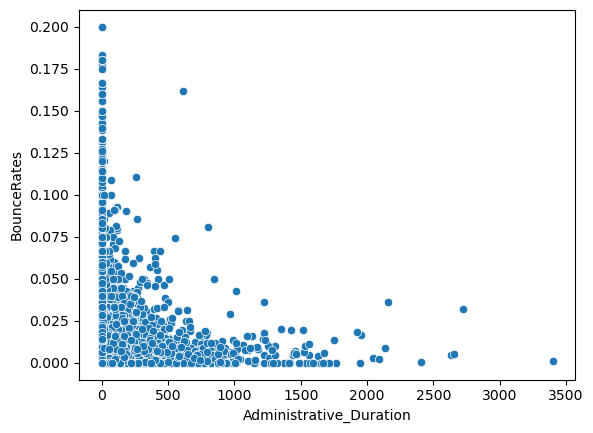

In [109]:
sns.scatterplot(merged_df, x="Administrative_Duration", y = "BounceRates")

There are some interesting traits to note about this bounce/ exit rates. First, it is observed that users were mostly likely to leave a web page on viewing the product information. This could suggest that reading the product details was enough for a user to determine if they were interested in viewing more/ purchasing an product (to be continued)

<Axes: xlabel='Weekend', ylabel='Revenue'>

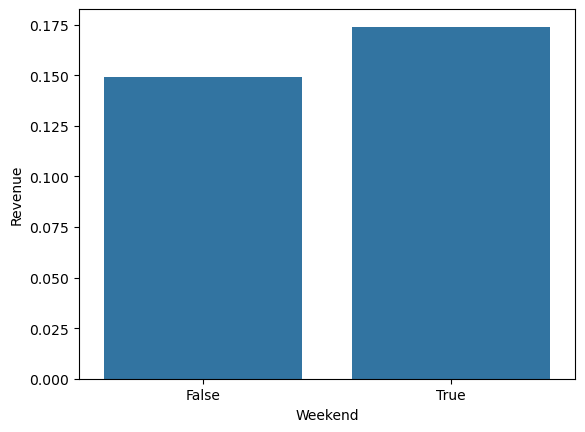

In [112]:
sns.barplot(merged_df, x= "Weekend", y = "Revenue", errorbar=None)

<Axes: xlabel='Weekend', ylabel='PageValues'>

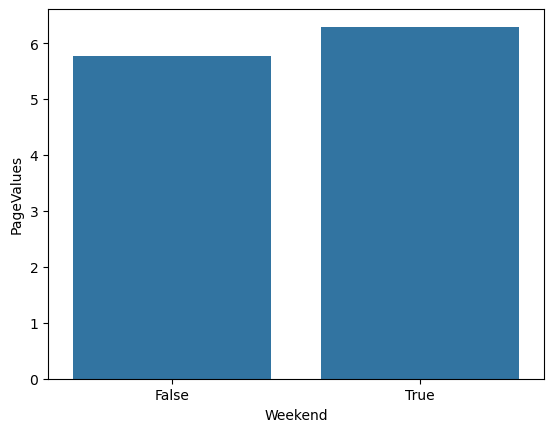

In [114]:
sns.barplot(merged_df, x= "Weekend", y = "PageValues", errorbar=None)

<Axes: xlabel='Weekend', ylabel='count'>

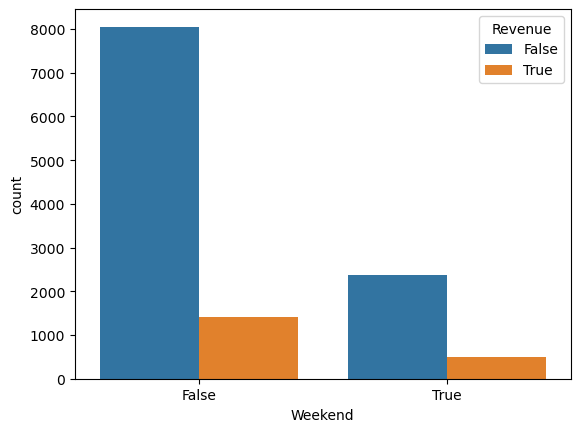

In [116]:
sns.countplot(merged_df, x= "Weekend", hue = "Revenue")

<Axes: xlabel='SpecialDay', ylabel='count'>

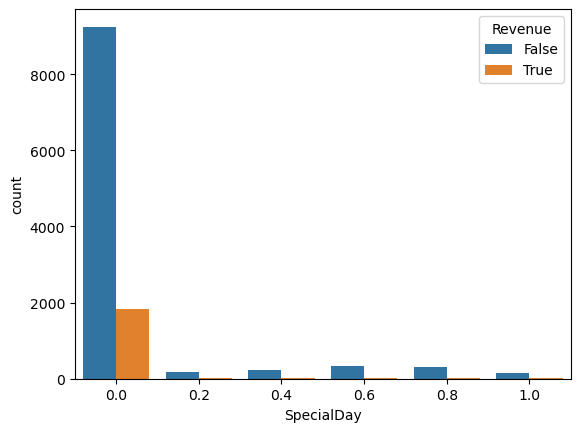

In [118]:
sns.countplot(merged_df, x= "SpecialDay", hue = "Revenue")

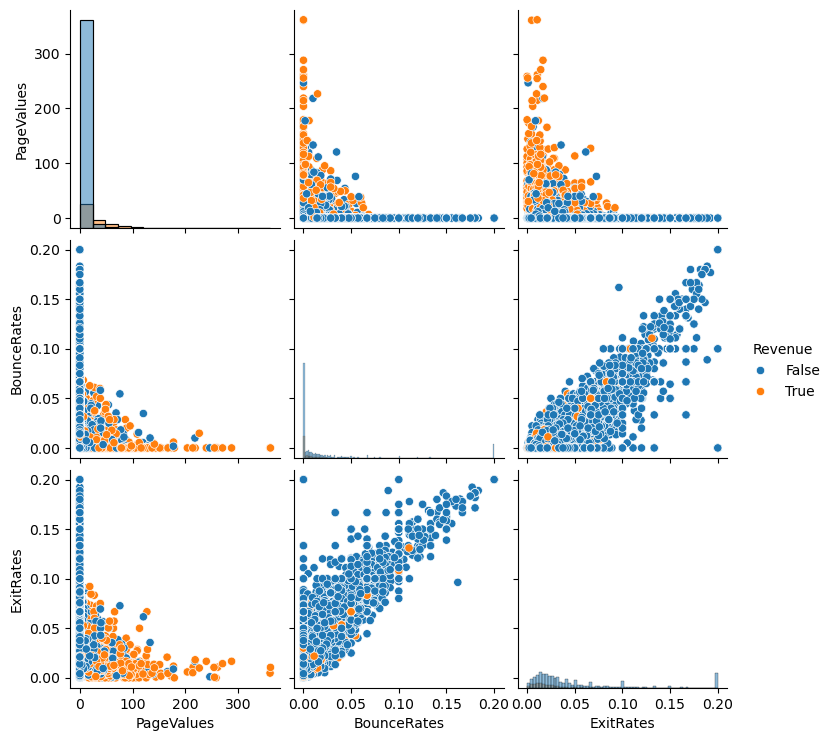

In [120]:
sns.pairplot(merged_df, vars=["PageValues", "BounceRates", "ExitRates"], hue="Revenue", diag_kind="hist")

The data shows relationships between values within columns that do, or tend to nor result in a purchase. This is important to consider in light of the weak-moderate correlations within the dataset. While the variables within the dataset might have low correlation, some factors within the dataset are indicative of a highler likelihood of conversation than others. At the same time, higher likelihood of conversation, here, has mimxed value to business insights if the overall sum of purchases is low. This is only sometimes the case within the dataset, emphasizing the inherent nuances. 

A few notable insights:

1) Likelihood of conversation was mixed across users from different operating systems. While group 8 had the highest likelihood of conversation, they also represent a relatively smaller sum of purchases. Keeping in mind, this also represented a relatively smaller number of consumers. This means that if a user from group 8 accesses the webpage content, for some (currently unknown) reason they would more likely be making a purchase. 

2) Trends like counts within a value for each variable are, well, variable across predictors here. For example, there is class imbalance in visitory type, and # of purchases varying greatly across the months.

3) Factors like exit and bounce rates have some interesting traits. For example, most users seem to leave without viewing much or any information at all without making a purcahse. If they do start to visit facotrs like informational, admin, product related, factors of exit and bounce rates drop and stabilize across values.

Simply put, there are nuances within the dataset, meaning feature selection would respectively benefit from considering these factors. Because I am simply experimenting here, I have some feature selection and model options to consider. Previous research includes approaches like principle component analysis, or more maunaul discretized mutual information approaches. As the dataset shows unique converstion rates, with moderate to low correlation, I will experiment with manual discretization on sum of revenue and likelihood of conversion. Class imbalances will be handled through SMOTE as a first step.  

In [122]:
# Outlier detection/ removal


In [ ]:
df_encoded.info()

MI Top 15 Features):
PageValues                       0.357716
ExitRates                        0.186076
BounceRates                      0.153770
Administrative_Duration          0.122561
ProductRelated_Duration          0.093178
Informational_Duration           0.056369
ProductRelated                   0.052514
SpecialDay                       0.048768
Month_May                        0.040251
VisitorType_Returning_Visitor    0.037633
OperatingSystems_3               0.037160
TrafficType_3                    0.035598
Month_Mar                        0.029256
Region_3                         0.021411
Month_Dec                        0.021396
dtype: float64


/var/folders/vp/zgl5wtv93gxgjlr0qhmm5_h80000gn/T/ipykernel_73171/4065053320.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


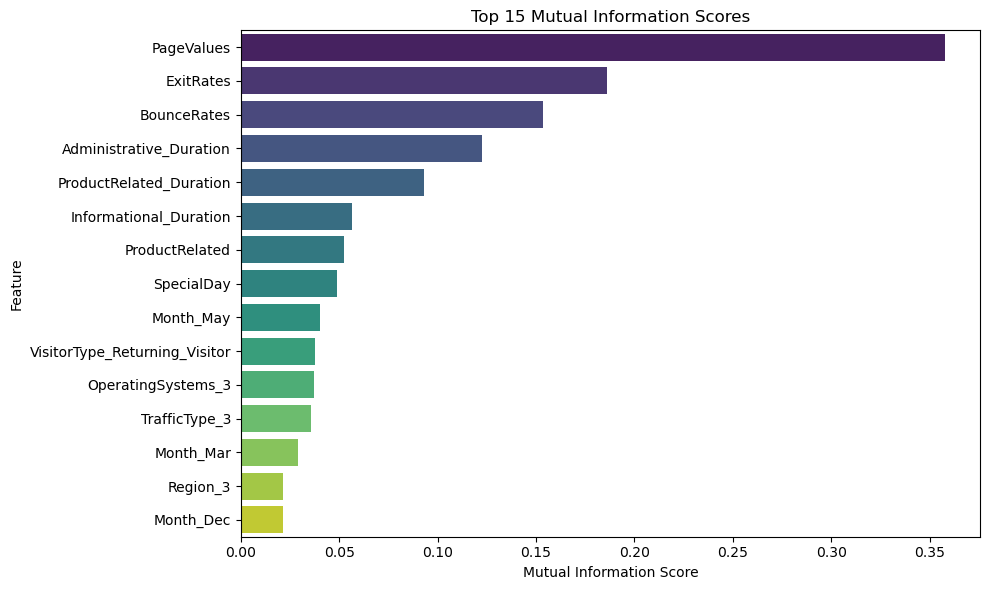

In [148]:
X= df_encoded.drop(columns=['Revenue']).copy()
y= df_encoded['Revenue']


smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

discrete_features_mask = X_res.columns.isin(
    list(X_res.columns[X_res.nunique() <= 2])
)

mi_scores = mutual_info_classif(
    X_res, y_res, discrete_features=discrete_features_mask
)

mi_series = pd.Series(mi_scores, index=X_res.columns).sort_values(ascending=False)

print("MI Top 15 Features):")
print(mi_series.head(15))

plt.figure(figsize=(10, 6))
sns.barplot(
    x=mi_series.head(15).values,
    y=mi_series.head(15).index,
    palette='viridis'
)
plt.title("Top 15 Mutual Information Scores")
plt.xlabel("Mutual Information Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


Top 15 Features
                    Feature      Chi_Score        p_value
5   ProductRelated_Duration  877404.339415   0.000000e+00
8                PageValues  175126.808512   0.000000e+00
1   Administrative_Duration   41754.836841   0.000000e+00
3    Informational_Duration   35059.775770   0.000000e+00
4            ProductRelated   19317.285376   0.000000e+00
0            Administrative    1133.965531  1.370161e-248
2             Informational     357.981605   7.746170e-80
16                Month_Nov     223.548231   1.522129e-50
49            TrafficType_2     113.937321   1.344933e-26
50            TrafficType_3      70.477528   4.655395e-17
15                Month_May      54.997108   1.207073e-13
9                SpecialDay      53.797094   2.223012e-13
60           TrafficType_13      52.519206   4.260613e-13
23       OperatingSystems_3      48.546233   3.225933e-12
14                Month_Mar      42.613274   6.670517e-11


/var/folders/vp/zgl5wtv93gxgjlr0qhmm5_h80000gn/T/ipykernel_73171/1977616114.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


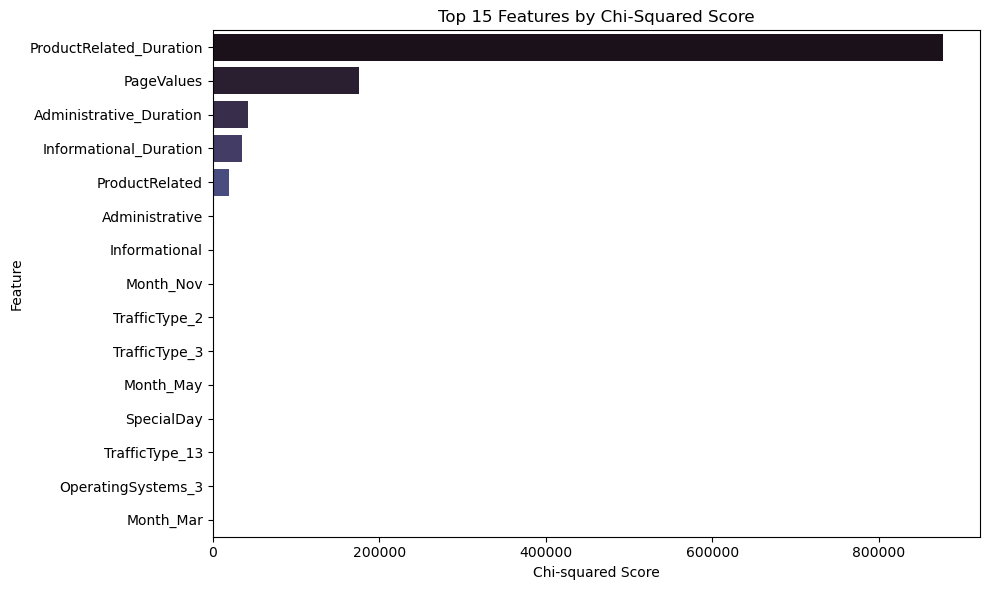

In [152]:
X_chi = df_encoded.drop(columns=['Revenue'])
y_chi = df_encoded['Revenue']

selector = SelectKBest(score_func=chi2, k='all')
selector.fit(X_chi, y_chi)

chi_df = pd.DataFrame({
    'Feature': X_chi.columns,
    'Chi_Score': selector.scores_,
    'p_value': selector.pvalues_
}).sort_values(by='Chi_Score', ascending=False)

print("Top 15 Features")
print(chi_df.head(15))

plt.figure(figsize=(10, 6))
sns.barplot(
    x=chi_df.head(15)['Chi_Score'],
    y=chi_df.head(15)['Feature'],
    palette='mako'
)
plt.title("Top 15 Features by Chi-Squared Score")
plt.xlabel("Chi-squared Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [154]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf.fit(X, y)

rf_df = pd.DataFrame({
    'Feature': X.columns,
    'RF_Importance': rf.feature_importances_
}).sort_values(by='RF_Importance', ascending=False)

print("Top 15 Features by Random Forest")
rf_df.head(15)

Top 15 Features by Random Forest


,Feature,RF_Importance
8,PageValues,0.336164
7,ExitRates,0.085299
5,ProductRelated_Duration,0.084190
4,ProductRelated,0.072641
1,Administrative_Duration,0.056242
6,BounceRates,0.054533
0,Administrative,0.043733
3,Informational_Duration,0.026677
16,Month_Nov,0.020929
2,Informational,0.018929


In [184]:
chi2_df = pd.DataFrame({
    'Feature': X.columns,
    'Chi_Score': selector.scores_,
    'p_value': selector.pvalues_
})

mi_df = pd.DataFrame({
    'Feature': mi_series.index,
    'MI_Score': mi_series.values
})

rf_df = pd.DataFrame({
    'Feature': X.columns,
    'RF_Importance': rf.feature_importances_
})

combined = (
    chi2_df
    .merge(mi_df, on='Feature')
    .merge(rf_df, on='Feature')
    .sort_values(by='RF_Importance', ascending=False)
)

combined.head(30)

,Feature,Chi_Score,p_value,MI_Score,RF_Importance
8,PageValues,175126.808512,0.000000e+00,0.357716,0.336164
7,ExitRates,28.985072,7.293821e-08,0.186076,0.085299
5,ProductRelated_Duration,877404.339415,0.000000e+00,0.093178,0.084190
4,ProductRelated,19317.285376,0.000000e+00,0.052514,0.072641
1,Administrative_Duration,41754.836841,0.000000e+00,0.122561,0.056242
6,BounceRates,29.654336,5.163700e-08,0.153770,0.054533
0,Administrative,1133.965531,1.370161e-248,0.020781,0.043733
3,Informational_Duration,35059.775770,0.000000e+00,0.056369,0.026677
16,Month_Nov,223.548231,1.522129e-50,0.000046,0.020929
2,Informational,357.981605,7.746170e-80,0.008393,0.018929


In [198]:
top_features = mi_series.head(15).index.tolist()
X_selected = X_res[top_features]


X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_res, test_size=0.2, random_state=42, stratify=y_res
)

svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=1.0, gamma='scale', probability=True))
])

svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8865435356200527

Confusion Matrix:
 [[1844  241]
 [ 232 1852]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.88      0.89      2085
           1       0.88      0.89      0.89      2084

    accuracy                           0.89      4169
   macro avg       0.89      0.89      0.89      4169
weighted avg       0.89      0.89      0.89      4169



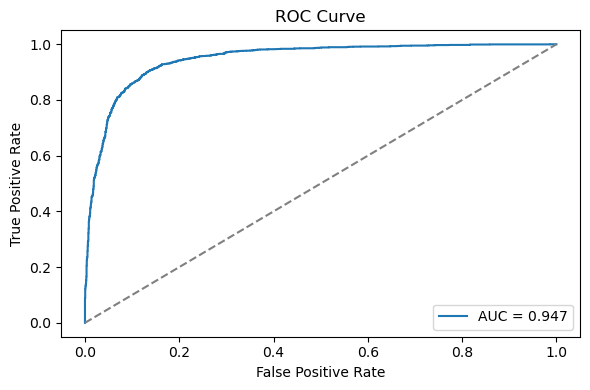

In [130]:
from sklearn.metrics import roc_curve, roc_auc_score

y_prob = svm_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

In [190]:
select_30 = [
    'PageValues',
    'ExitRates',
    'ProductRelated_Duration',
    'ProductRelated',
    'Administrative_Duration',
    'BounceRates',
    'Administrative',
    'Informational_Duration',
    'Month_Nov',
    'Informational',
    'VisitorType_Returning_Visitor',
    'Weekend_True',
    'TrafficType_2',
    'Browser_2',
    'OperatingSystems_2',
    'Region_3',
    'OperatingSystems_3',
    'Month_May',
    'Region_2',
    'Region_4',
    'Month_Dec',
    'TrafficType_3',
    'Month_Mar',
    'Region_6',
    'Browser_4',
    'Region_7',
    'TrafficType_4',
    'TrafficType_8',
    'Region_9',
    'Month_Sep'
]


X_selected = X_res[select_30]


X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_res, test_size=0.2, random_state=42, stratify=y_res
)


svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=1.0, gamma='scale', probability=True))
])


svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Accuracy: 0.9045334612616934

Confusion Matrix:
 [[1932  153]
 [ 245 1839]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91      2085
           1       0.92      0.88      0.90      2084

    accuracy                           0.90      4169
   macro avg       0.91      0.90      0.90      4169
weighted avg       0.91      0.90      0.90      4169



In [172]:
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_res)

pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Number of components:", pca.n_components_)
print("Explained variance ratio sum:", pca.explained_variance_ratio_.sum())

Number of components: 56
Explained variance ratio sum: 0.9537764760799121


In [174]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y_res, test_size=0.2, random_state=42, stratify=y_res
)

svm_pca = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)

svm_pca.fit(X_train, y_train)
y_pred = svm_pca.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9122091628687935

Confusion Matrix:
 [[1978  107]
 [ 259 1825]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.95      0.92      2085
           1       0.94      0.88      0.91      2084

    accuracy                           0.91      4169
   macro avg       0.91      0.91      0.91      4169
weighted avg       0.91      0.91      0.91      4169



In [192]:
rf_clf = RandomForestClassifier(
    n_estimators=300,       
    max_depth=None,         
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    class_weight='balanced',  
    n_jobs=-1               
)


rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9393139841688655

Confusion Matrix:
 [[1957  128]
 [ 125 1959]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      2085
           1       0.94      0.94      0.94      2084

    accuracy                           0.94      4169
   macro avg       0.94      0.94      0.94      4169
weighted avg       0.94      0.94      0.94      4169



In [194]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Build model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(256, activation='relu'),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train_scaled, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2
)

y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 676us/step - accuracy: 0.8400 - loss: 0.3611 - val_accuracy: 0.8990 - val_loss: 0.2445
Epoch 2/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - accuracy: 0.9036 - loss: 0.2324 - val_accuracy: 0.8996 - val_loss: 0.2297
Epoch 3/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - accuracy: 0.9146 - loss: 0.2080 - val_accuracy: 0.9073 - val_loss: 0.2190
Epoch 4/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - accuracy: 0.9161 - loss: 0.2012 - val_accuracy: 0.9097 - val_loss: 0.2153
Epoch 5/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - accuracy: 0.9244 - loss: 0.1815 - val_accuracy: 0.9124 - val_loss: 0.2103
Epoch 6/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - accuracy: 0.9248 - loss: 0.1721 - val_accuracy: 0.9091 - val_loss: 0.2194
Epoch 7/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - accuracy: 0.9307 - loss: 0.1689 - val_accuracy: 0.9061 - val_loss: 0.2226
Epoch 8/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - accuracy: 0.9291 - loss: 0.1692 - val_accurac

In [ ]:
bin - encode - smote

In [136]:
df_chi=df_encoded.drop(columns = binned_cols + binned_code_cols)
df_chi.info()

NameError: name 'binned_cols' is not defined

In [196]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


xgb_clf_v1 = XGBClassifier(
    n_estimators=300,      
    max_depth=6,           
    learning_rate=0.05,    
    subsample=0.8,         
    colsample_bytree=0.8,  
    gamma=0,               
    reg_lambda=1,          
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

xgb_clf_v1.fit(X_train, y_train)

y_pred_xgb = xgb_clf_v1.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))


Accuracy: 0.9330774766130967

Confusion Matrix:
 [[1947  138]
 [ 141 1943]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      2085
           1       0.93      0.93      0.93      2084

    accuracy                           0.93      4169
   macro avg       0.93      0.93      0.93      4169
weighted avg       0.93      0.93      0.93      4169

